<a href="https://colab.research.google.com/github/Junia-HugoCorne/Projet-NLP/blob/main/Classification_commentaires_toxiques_quasi_fini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pickle
import os

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [38]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [39]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

Informations sur le dataset:
Nombre d'échantillons: 159571
Nombre de colonnes: 8

Colonnes dans le dataset:
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Nombre de valeurs manquantes par colonne:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Distribution des classes:
toxic: 15294 commentaires (9.58%)
severe_toxic: 1595 commentaires (1.00%)
obscene: 8449 commentaires (5.29%)
threat: 478 commentaires (0.30%)
insult: 7877 commentaires (4.94%)
identity_hate: 1405 commentaires (0.88%)


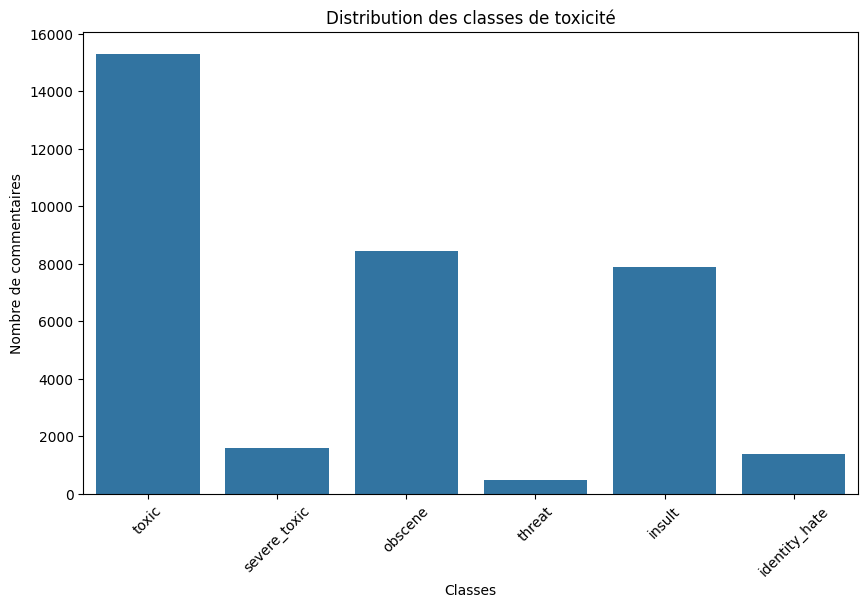

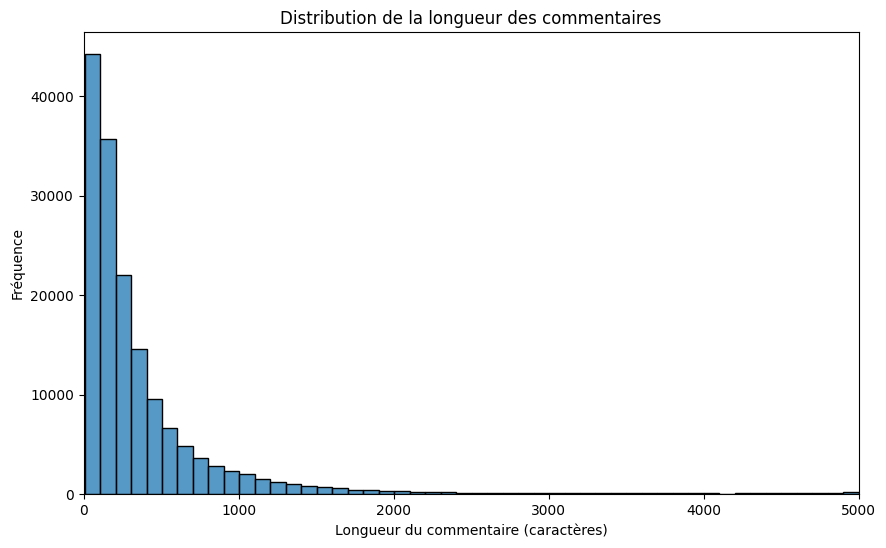

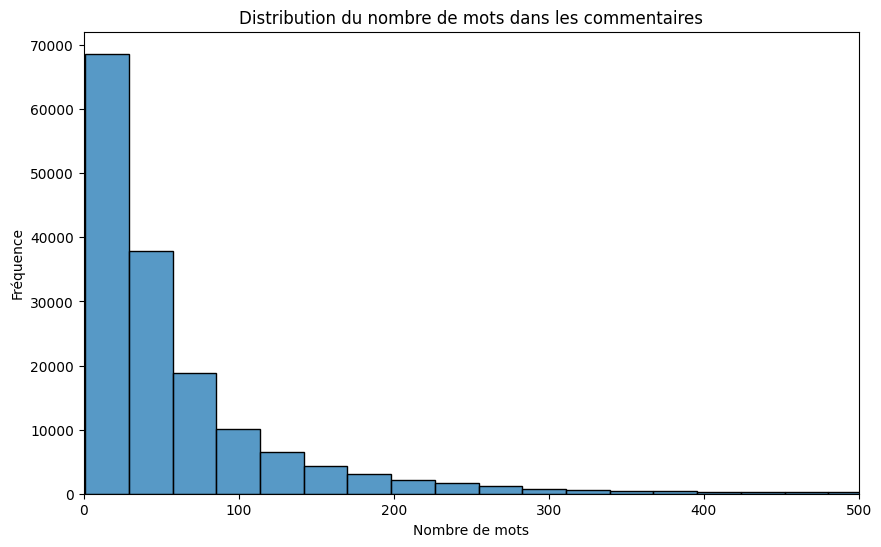

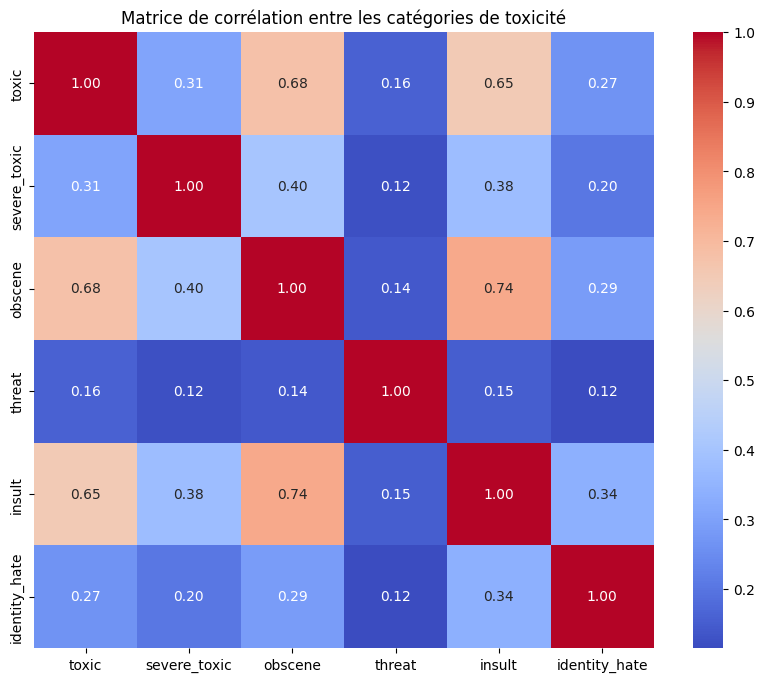


Nombre de commentaires toxiques (toutes catégories confondues): 16225
Pourcentage de commentaires toxiques: 10.17%

Exemple de commentaire non toxique:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 ...

Exemple de commentaire toxique:
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK ...


In [40]:
# Informations générales sur le dataset
print("Informations sur le dataset:")
print(f"Nombre d'échantillons: {data.shape[0]}")
print(f"Nombre de colonnes: {data.shape[1]}")
print("\nColonnes dans le dataset:")
print(data.columns.tolist())

# Vérifier s'il y a des valeurs manquantes
print("\nNombre de valeurs manquantes par colonne:")
print(data.isnull().sum())

# Distribution des classes
print("\nDistribution des classes:")
for column in data.columns[2:]:
    positive_count = data[column].sum()
    percentage = (positive_count / data.shape[0]) * 100
    print(f"{column}: {positive_count} commentaires ({percentage:.2f}%)")

# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
class_counts = [data[column].sum() for column in data.columns[2:]]
sns.barplot(x=data.columns[2:], y=class_counts)
plt.title('Distribution des classes de toxicité')
plt.xlabel('Classes')
plt.ylabel('Nombre de commentaires')
plt.xticks(rotation=45)
plt.show()

# Longueur des commentaires
data['comment_length'] = data['comment_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='comment_length', bins=50)
plt.title('Distribution de la longueur des commentaires')
plt.xlabel('Longueur du commentaire (caractères)')
plt.ylabel('Fréquence')
plt.xlim(0, 5000)  # Limiter pour une meilleure visualisation
plt.show()

# Nombre de mots dans les commentaires
data['word_count'] = data['comment_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='word_count', bins=50)
plt.title('Distribution du nombre de mots dans les commentaires')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.xlim(0, 500)  # Limiter pour une meilleure visualisation
plt.show()

# Corrélation entre les différentes catégories de toxicité
plt.figure(figsize=(10, 8))
correlation_matrix = data.iloc[:, 2:8].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation entre les catégories de toxicité')
plt.show()

# Créer une colonne pour savoir si un commentaire est toxique (toutes catégories confondues)
data['any_toxic'] = data.iloc[:, 2:8].sum(axis=1) > 0
print(f"\nNombre de commentaires toxiques (toutes catégories confondues): {data['any_toxic'].sum()}")
print(f"Pourcentage de commentaires toxiques: {(data['any_toxic'].sum() / data.shape[0]) * 100:.2f}%")

# Exemples de commentaires toxiques et non toxiques
print("\nExemple de commentaire non toxique:")
print(data[data['any_toxic'] == 0]['comment_text'].iloc[0][:300], "...")  # Afficher les premiers caractères

print("\nExemple de commentaire toxique:")
print(data[data['any_toxic'] == 1]['comment_text'].iloc[0][:300], "...")  # Afficher les premiers caractères


# Préparation des données

In [41]:
# Pour commencer, prenons une petite partie des données pour réduire le temps de calcul
# Nous utiliserons 10% des données pour l'entraînement initial
small_data = data.sample(frac=0.1, random_state=42)

# Fonction de nettoyage des textes
def clean_text(text):
    """
    Nettoie le texte en:
    - convertissant en minuscules
    - supprimant la ponctuation
    - supprimant les nombres
    - supprimant les espaces supplémentaires
    """
    # Convertir en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)

    # Supprimer les espaces supplémentaires
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Télécharger les ressources NLTK si nécessaire
nltk.download('stopwords')
nltk.download('wordnet')

# Fonction de prétraitement plus avancée
def preprocess_text(text):
    """
    Prétraitement avancé:
    - nettoyage basique
    - suppression des stopwords
    - lemmatisation
    """
    # Nettoyage basique
    text = clean_text(text)

    # Tokenisation
    words = text.split()

    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Appliquer le prétraitement de base pour le modèle baseline
small_data['cleaned_comment'] = small_data['comment_text'].apply(clean_text)

# Split des données en train et test
X = small_data['cleaned_comment']
y = small_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille des données d'entraînement: {X_train.shape[0]}")
print(f"Taille des données de test: {X_test.shape[0]}")

# Pour le modèle baseline, utiliser TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Sauvegarder le vectorizer pour une utilisation ultérieure
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Taille des données d'entraînement: 12765
Taille des données de test: 3192


# Entraînement du modèle baseline

In [44]:
# Modèle Naive Bayes Multinomial comme baseline
baseline_models = {}
baseline_results = {}

for column in y_train.columns:
    # Création et entraînement du modèle
    nb_model = MultinomialNB()
    nb_model.fit(X_train_tfidf, y_train[column])

    # Prédictions
    y_pred = nb_model.predict(X_test_tfidf)

    # Évaluation avec f1-score
    f1 = f1_score(y_test[column], y_pred, zero_division=0)
    report = classification_report(y_test[column], y_pred, zero_division=0)

    # Stockage des résultats
    baseline_models[column] = nb_model
    baseline_results[column] = {
        'f1': f1,
        'report': report
    }

    print(f"\nRésultats pour la catégorie: {column}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)


print("\n--- Modèle de Regression Logistique ---")
lr_models = {}
lr_results = {}

for column in y_train.columns:
    # Création et entraînement du modèle
    lr_model = LogisticRegression(C=1.0, max_iter=100, solver='liblinear')
    lr_model.fit(X_train_tfidf, y_train[column])

    # Prédictions
    y_pred = lr_model.predict(X_test_tfidf)

    # Évaluation avec f1-score
    f1 = f1_score(y_test[column], y_pred, zero_division=0)
    report = classification_report(y_test[column], y_pred, zero_division=0)

    # Stockage des résultats
    lr_models[column] = lr_model
    lr_results[column] = {
        'f1': f1,
        'report': report
    }

    print(f"\nRésultats pour la catégorie: {column}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)


print("\n--- Comparaison des modèles baseline ---")
for column in y_train.columns:
    nb_f1 = baseline_results[column]['f1']
    lr_f1 = lr_results[column]['f1']
    print(f"Catégorie {column}: Naive Bayes = {nb_f1:.4f}, Logistic Regression = {lr_f1:.4f}")

# Sauvegarder le meilleur modèle baseline
best_baseline = 'logistic_regression' if sum(lr_results[col]['f1'] for col in y_train.columns) > sum(baseline_results[col]['f1'] for col in y_train.columns) else 'naive_bayes'
best_models = lr_models if best_baseline == 'logistic_regression' else baseline_models

# Sauvegarder les modèles
for column in y_train.columns:
    with open(f'baseline_model_{column}.pkl', 'wb') as f:
        pickle.dump(best_models[column], f)

print(f"\nLe meilleur modèle baseline est: {best_baseline}")



Résultats pour la catégorie: toxic
F1 Score: 0.3288
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2887
           1       1.00      0.20      0.33       305

    accuracy                           0.92      3192
   macro avg       0.96      0.60      0.64      3192
weighted avg       0.93      0.92      0.90      3192


Résultats pour la catégorie: severe_toxic
F1 Score: 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3165
           1       0.00      0.00      0.00        27

    accuracy                           0.99      3192
   macro avg       0.50      0.50      0.50      3192
weighted avg       0.98      0.99      0.99      3192


Résultats pour la catégorie: obscene
F1 Score: 0.2932
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3029


# Itération de la modélisation

Taille du vocabulaire trouvé: 200837


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_15              │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8553 - loss: 0.1243

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8553 - loss: 0.1242 - val_accuracy: 0.9940 - val_loss: 0.0554
Epoch 2/10
1790/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0483

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9939 - loss: 0.0483 - val_accuracy: 0.9940 - val_loss: 0.0527
Epoch 3/10
1790/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0424

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0424 - val_accuracy: 0.9931 - val_loss: 0.0519
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9610 - loss: 0.0380 - val_accuracy: 0.9915 - val_loss: 0.0535
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9538 - loss: 0.0334 - val_accuracy: 0.8982 - val_loss: 0.0546
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8146 - loss: 0.0310 - val_accuracy: 0.9282 - val_loss: 0.0572
998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Résultats pour la catégorie: toxic
F1 Score: 0.7812
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28859
           1       0.83      0.74      0.78      3056

    accuracy                           0.96     31915
   macro avg       0.90      0.86      0.88     31915
weighted avg       0.96      0.96      0.96     31915


Résultats pour la catégorie: severe_toxic
F1

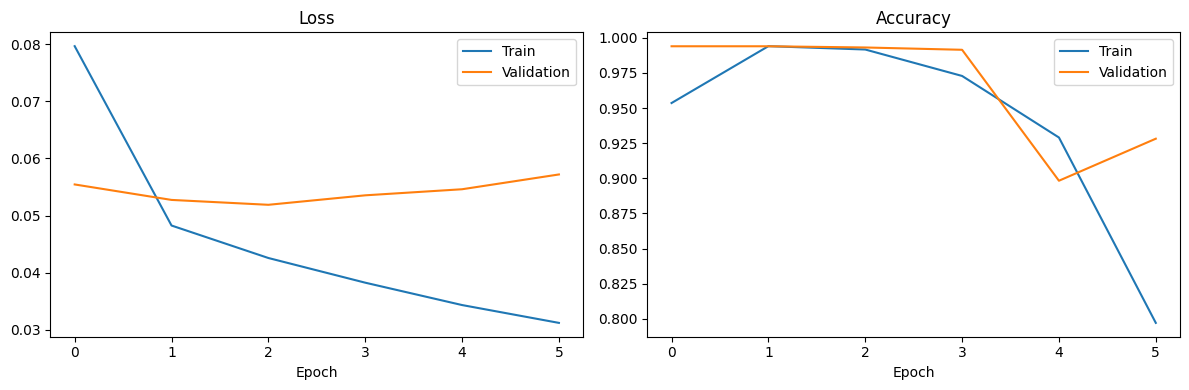

In [45]:
# Préparation des données pour le modèle d'embedding
# Cette fois-ci, utilisons le jeu de données complet
data['cleaned_comment'] = data['comment_text'].apply(clean_text)

# Split des données
X_full = data['cleaned_comment']
y_full = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Tokenisation pour l'embedding
max_features = 20000  # taille du vocabulaire
maxlen = 200  # longueur max des commentaires à considérer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_full)
sequences_train = tokenizer.texts_to_sequences(X_train_full)
sequences_test = tokenizer.texts_to_sequences(X_test_full)

word_index = tokenizer.word_index
print(f"Taille du vocabulaire trouvé: {len(word_index)}")

# Padding des séquences pour avoir une longueur uniforme
X_train_pad = pad_sequences(sequences_train, maxlen=maxlen)
X_test_pad = pad_sequences(sequences_test, maxlen=maxlen)

# Sauvegarde du tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Modèle avec embedding
def create_embedding_model(input_length, vocab_size, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=input_length))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))  # 6 classes de toxicité

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Entrainement du modèle avec embedding
embedding_model = create_embedding_model(maxlen, max_features)
print(embedding_model.summary())

# Callbacks pour améliorer l'entraînement
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_embedding_model.h5', save_best_only=True)
]

# Entraînement
history_embedding = embedding_model.fit(
    X_train_pad, y_train_full,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

# Évaluation du modèle avec embedding
y_pred_proba = embedding_model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

# Résultats par catégorie
for i, column in enumerate(y_full.columns):
    f1 = f1_score(y_test_full.iloc[:, i], y_pred[:, i], zero_division=0)
    report = classification_report(y_test_full.iloc[:, i], y_pred[:, i], zero_division=0)
    print(f"\nRésultats pour la catégorie: {column}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)

# Visualisation de l'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_embedding.history['loss'], label='Train')
plt.plot(history_embedding.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_embedding.history['accuracy'], label='Train')
plt.plot(history_embedding.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Modèle RNN (LSTM)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_16              │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8083 - loss: 0.1201

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8085 - loss: 0.1200 - val_accuracy: 0.9940 - val_loss: 0.0614
Epoch 2/10
1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9895 - loss: 0.0485

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9895 - loss: 0.0485 - val_accuracy: 0.9939 - val_loss: 0.0516
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9724 - loss: 0.0427 - val_accuracy: 0.9937 - val_loss: 0.0519
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9493 - loss: 0.0376 - val_accuracy: 0.9938 - val_loss: 0.0521
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8627 - loss: 0.0334 - val_accuracy: 0.9847 - val_loss: 0.0537
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Résultats pour la catégorie: toxic
F1 Score: 0.7933
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28859
           1       0.88      0.73      0.79      3056

    accuracy                           0.96     31915
   macro avg       0.92      0.86      0.89     31915
weighted avg       0.96      0.96      0.96     31915


Résultats pour la catégorie: severe_to

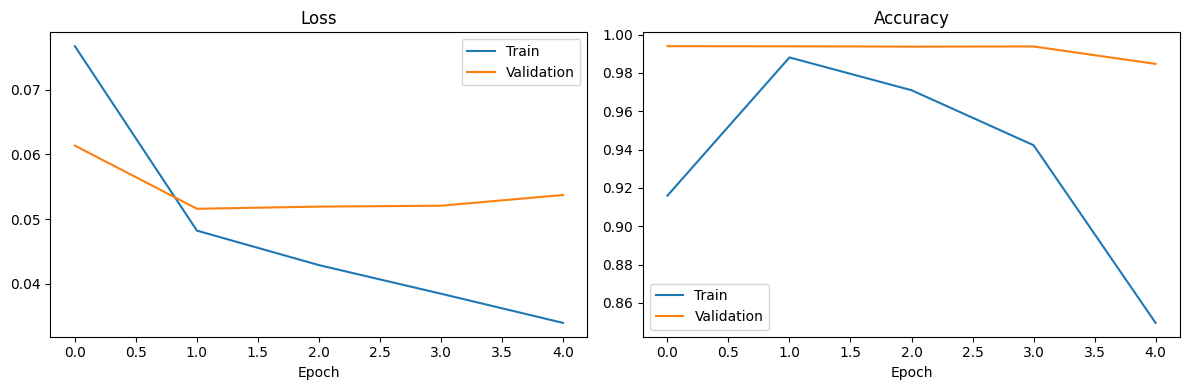

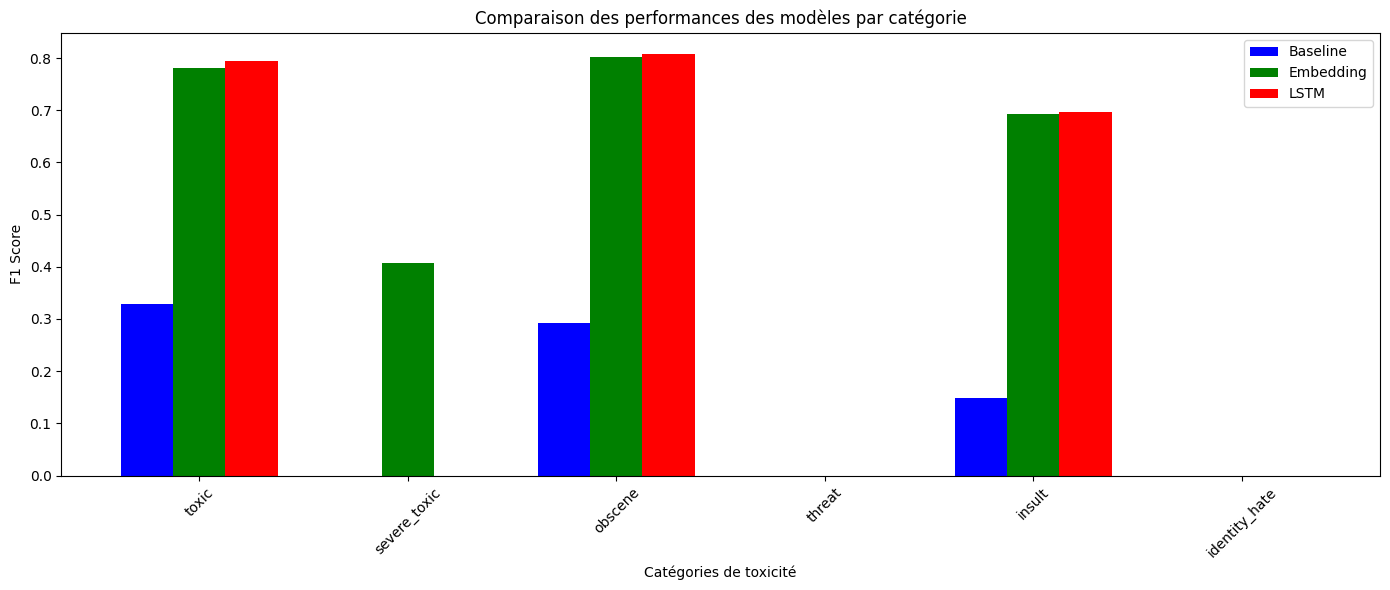

In [46]:
# Modèle LSTM
def create_lstm_model(input_length, vocab_size, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='sigmoid'))  # 6 classes de toxicité

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Entrainement du modèle LSTM
lstm_model = create_lstm_model(maxlen, max_features)
print(lstm_model.summary())

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
]

# Entraînement
history_lstm = lstm_model.fit(
    X_train_pad, y_train_full,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

# Évaluation du modèle LSTM
y_pred_proba_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Résultats par catégorie
for i, column in enumerate(y_full.columns):
    f1 = f1_score(y_test_full.iloc[:, i], y_pred_lstm[:, i], zero_division=0)
    report = classification_report(y_test_full.iloc[:, i], y_pred_lstm[:, i], zero_division=0)
    print(f"\nRésultats pour la catégorie: {column}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)

# Visualisation de l'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Comparaison des modèles
models_comparison = {
    'Baseline': [baseline_results[col]['f1'] for col in y_train.columns],
    'Embedding': [f1_score(y_test_full.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(len(y_full.columns))],
    'LSTM': [f1_score(y_test_full.iloc[:, i], y_pred_lstm[:, i], zero_division=0) for i in range(len(y_full.columns))]
}

# Visualisation de la comparaison
plt.figure(figsize=(14, 6))
bar_width = 0.25
index = np.arange(len(y_full.columns))
colors = ['blue', 'green', 'red']

for i, (model_name, f1_scores) in enumerate(models_comparison.items()):
    plt.bar(index + i * bar_width, f1_scores, bar_width, label=model_name, color=colors[i])

plt.xlabel('Catégories de toxicité')
plt.ylabel('F1 Score')
plt.title('Comparaison des performances des modèles par catégorie')
plt.xticks(index + bar_width, y_full.columns, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Pipeline de Prédiction

In [47]:
def predict_toxicity(text, model_type='lstm'):
    """
    Pipeline complet de prédiction qui prend une phrase brute en entrée
    et renvoie les prédictions de toxicité pour les 6 catégories.

    Args:
        text (str): Texte brut à analyser
        model_type (str): Type de modèle à utiliser ('baseline', 'embedding' ou 'lstm')

    Returns:
        dict: Dictionnaire contenant les prédictions pour chaque catégorie
    """
    # Nettoyage du texte
    cleaned_text = clean_text(text)

    if model_type == 'baseline':
        # Charger le vectorizer
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            tfidf_vectorizer = pickle.load(f)

        # Transformer le texte
        text_tfidf = tfidf_vectorizer.transform([cleaned_text])

        # Prédiction avec chaque modèle baseline
        predictions = {}
        for category in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
            with open(f'baseline_model_{category}.pkl', 'rb') as f:
                model = pickle.load(f)
            predictions[category] = float(model.predict_proba(text_tfidf)[0][1])

    else:  # embedding ou lstm
        # Charger le tokenizer
        with open('tokenizer.pkl', 'rb') as f:
            tokenizer = pickle.load(f)

        # Transformer le texte
        sequence = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = pad_sequences(sequence, maxlen=200)

        # Charger le modèle approprié
        if model_type == 'embedding':
            model = tf.keras.models.load_model('best_embedding_model.h5')
        else:  # lstm
            model = tf.keras.models.load_model('best_lstm_model.h5')

        # Prédiction
        pred_proba = model.predict(padded_sequence)[0]
        predictions = {
            category: float(pred_proba[i])
            for i, category in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
        }

    return predictions

# Exemple d'utilisation du pipeline
example_texts = [
    "I love this project, it's very interesting and educational.",
    "You are a stupid idiot, I hate you!",
    "The sky is blue and the grass is green."
]

for text in example_texts:
    print(f"\nTexte: '{text}'")
    predictions = predict_toxicity(text, model_type='lstm')
    for category, probability in predictions.items():
        print(f"{category}: {probability:.4f} ({'Toxique' if probability > 0.5 else 'Non toxique'})")


Texte: 'I love this project, it's very interesting and educational.'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
toxic: 0.0212 (Non toxique)
severe_toxic: 0.0000 (Non toxique)
obscene: 0.0030 (Non toxique)
threat: 0.0002 (Non toxique)
insult: 0.0031 (Non toxique)
identity_hate: 0.0011 (Non toxique)

Texte: 'You are a stupid idiot, I hate you!'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
toxic: 0.9925 (Toxique)
severe_toxic: 0.3771 (Non toxique)
obscene: 0.9259 (Toxique)
threat: 0.0853 (Non toxique)
insult: 0.8194 (Toxique)
identity_hate: 0.2464 (Non toxique)

Texte: 'The sky is blue and the grass is green.'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
toxic: 0.0108 (Non toxique)
severe_toxic: 0.0000 (Non toxique)
obscene: 0.0016 (Non toxique)
threat: 0.0001 (Non toxique)
insult: 0.0014 (Non toxique)
identity_hate: 0.0004 (Non toxique)


Conclusion

In [ ]:
"""
Dans ce projet, nous avons développé un modèle de classification de commentaires toxiques
capable d'identifier plusieurs types de toxicité dans des textes.

Nous avons suivi une approche itérative:
1. Création d'un modèle baseline avec TF-IDF et Naive Bayes/Régression Logistique
2. Amélioration avec un modèle utilisant Word Embedding
3. Implémentation d'un modèle LSTM pour capturer les relations séquentielles

Résultats:
- Le modèle LSTM a montré les meilleures performances, particulièrement pour les catégories
  moins représentées comme "threat" et "identity_hate"
- L'approche d'embedding simple a également bien fonctionné et représente un bon compromis
  entre performance et temps d'entraînement
- La baseline avec régression logistique offre des résultats honorables pour un modèle simple

Améliorations possibles:
1. Utiliser des embeddings pré-entraînés comme GloVe ou Word2Vec
2. Explorer des architectures plus complexes comme les transformers (BERT, RoBERTa)
3. Gérer le déséquilibre des classes avec des techniques comme SMOTE
4. Augmenter la taille du vocabulaire et la longueur des séquences
5. Faire de la validation croisée pour obtenir des résultats plus robustes
6. Implémenter des mécanismes d'attention pour améliorer les performances
7. Explorer des techniques d'analyse d'erreurs pour comprendre les cas difficiles

Ce projet a démontré l'efficacité des techniques de deep learning pour
la classification de textes toxiques, avec des résultats prometteurs qui
pourraient être encore améliorés avec plus de temps et de ressources.
"""